In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Download data
# -------------------------------------------------------------------------------------
data_spy = yf.download("SPY", start="2000-01-01", end="2023-09-01", interval='1wk', progress=False)
data_vix = yf.download("^VIX", start="2000-01-01", end="2023-09-01", interval='1wk', progress=False)
data_10y = yf.download("^TNX", start="2000-01-01", end="2023-09-01", interval='1wk', progress=False)
data_2y = yf.download("^IRX", start="2000-01-01", end="2023-09-01", interval='1wk', progress=False)

# Rename Columns
data_spy = data_spy.rename(columns={
    'Close': 'Close_SPY',
    'High': 'High_SPY',
    'Low': 'Low_SPY',
    'Open': 'Open_SPY',
    'Volume': 'Volume_SPY'
})

data_vix = data_vix.rename(columns={
    'Close': 'Close_VIX'
})

data_10y = data_10y.rename(columns={
    'Close': 'Close_10Y'
})

data_2y = data_2y.rename(columns={
    'Close': 'Close_2Y'
})

# Filter columns
data_spy = data_spy[['Close_SPY', 'High_SPY', 'Low_SPY', 'Open_SPY', 'Volume_SPY']]
data_vix = data_vix[['Close_VIX']]
data_10y = data_10y[['Close_10Y']]
data_2y = data_2y[['Close_2Y']]

# Merge dataframes
data = pd.merge(data_spy, data_vix, left_index=True, right_index=True, how='inner')
data = pd.merge(data, data_10y, left_index=True, right_index=True, how='inner')
data = pd.merge(data, data_2y, left_index=True, right_index=True, how='inner')

print("Cell Completed")

Cell Completed


In [2]:
# Indicators
# -------------------------------------------------------------------------------------
def compute_rsi(data_: str("only Close"), window=14):
    delta = data_.diff()
    delta = delta[1:]
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_atr(data_: pd.DataFrame, window=14):
    high_low = data_['High_SPY'] - data_['Low_SPY']
    high_close = np.abs(data_['High_SPY'] - data_['Close_SPY'].shift())
    low_close = np.abs(data_['Low_SPY'] - data_['Close_SPY'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    atr = true_range.rolling(window=window).mean()
    return atr

def compute_volume_diff_perc(data_: pd.DataFrame, window=50) -> pd.DataFrame:
    data_['Volume_MA50'] = data_['Volume_SPY'].rolling(window=window).mean()
    data_['Volume_Diff'] = data_['Volume_SPY'] - data_['Volume_MA50']
    data_['Volume_Diff_Perc'] = (data_['Volume_Diff'] / data_['Volume_MA50']) * 100
    return data_['Volume_Diff_Perc']

def compute_return(data_: str("Only Close") , period_):
    return data_.pct_change(periods=period_)

print(data)

# RSI
data['RSI'] = compute_rsi(data['Close_SPY'])

# ATR
data['ATR'] = compute_atr(data)

# Volume
data['SPY Volume'] = compute_volume_diff_perc(data)

# VIX
data['VIX'] = data['Close_VIX']

# Yield Curve
data['Yield Curve'] = data['Close_10Y'] - data['Close_2Y']

# Price Change
data['Price Change'] = compute_return(data['Close_SPY'], 4)

print("Cell Completed")

             Close_SPY    High_SPY     Low_SPY    Open_SPY  Volume_SPY  \
Date                                                                     
2000-01-01  145.750000  148.250000  137.250000  148.250000    42725700   
2000-01-08  146.968750  147.468750  142.875000  146.250000    32748700   
2000-01-15  144.437500  147.000000  143.812500  145.343750    24691300   
2000-01-22  135.875000  145.843750  135.531250  145.656250    45836400   
2000-01-29  142.593750  144.000000  135.000000  135.812500    38317400   
...                ...         ...         ...         ...         ...   
2023-07-29  446.809998  458.160004  446.269989  457.410004   375593700   
2023-08-05  445.649994  451.700012  443.350006  448.709991   370178500   
2023-08-12  436.500000  448.109985  433.010010  444.700012   398151800   
2023-08-19  439.970001  445.220001  435.000000  437.549988   393065300   
2023-08-26  451.190002  453.670013  439.970001  442.239990   338691500   

            Close_VIX  Close_10Y  Clo

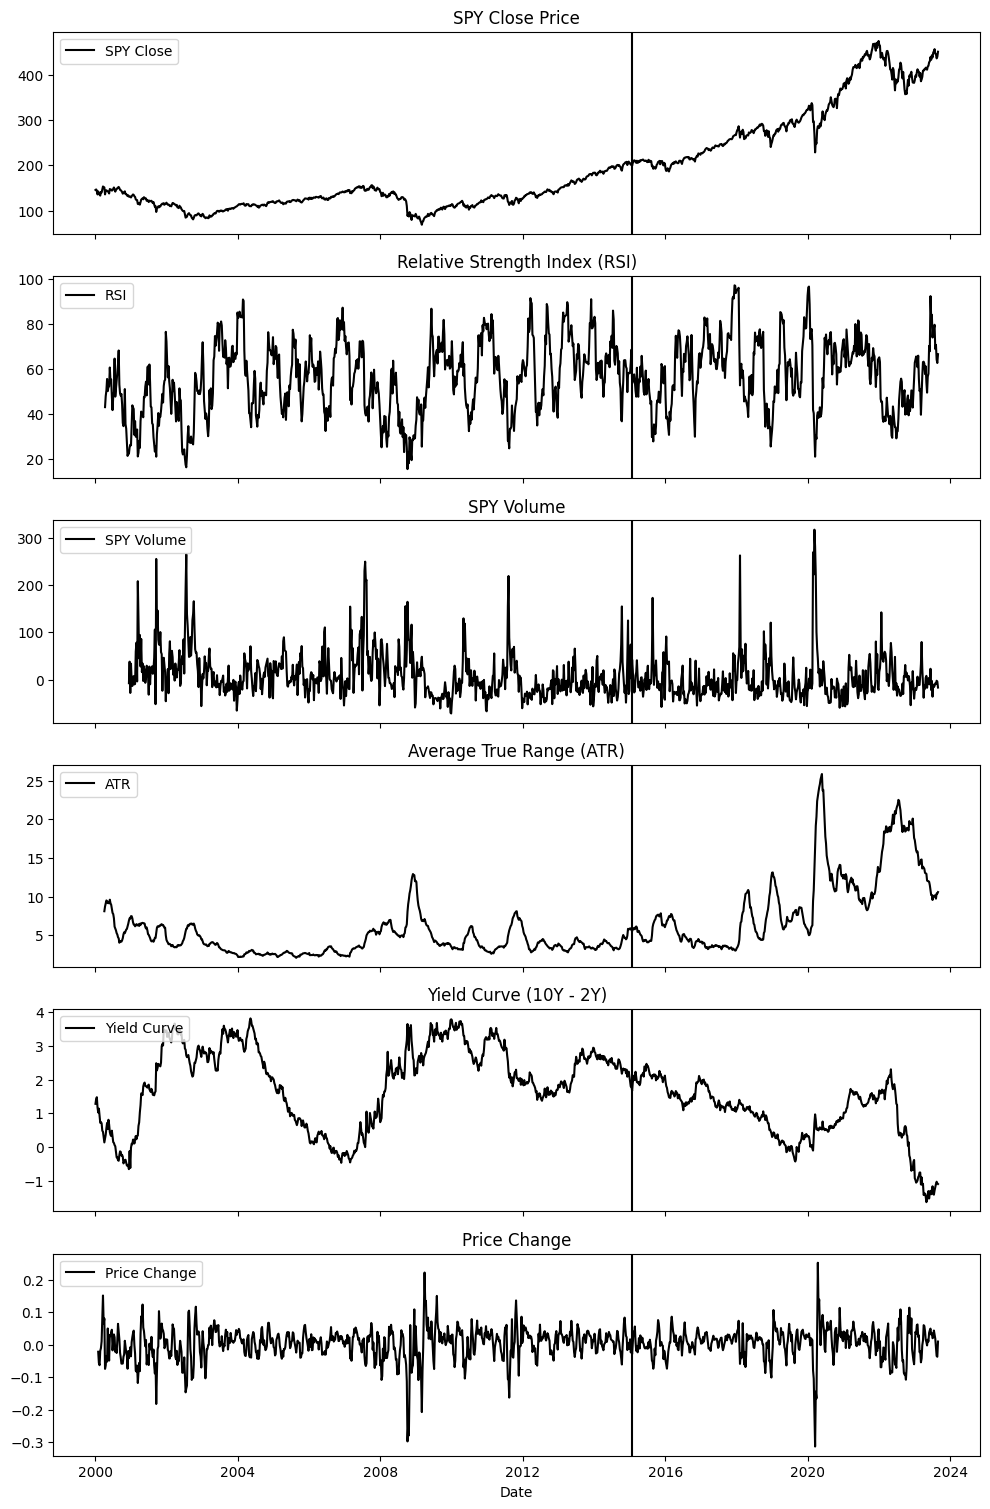

Cell Completed


In [3]:
import datetime

# Plotting Data
# -------------------------------------------------------------------------------------
fig, axarr = plt.subplots(6, 1, figsize=(10, 15), sharex=True)

# SPY Close Price
axarr[0].plot(data.index, data['Close_SPY'], label='SPY Close', color='black')
axarr[0].set_title('SPY Close Price')
axarr[0].axvline(datetime.date(2015, 1, 25), color = 'black')
axarr[0].legend(loc='upper left')

# RSI
axarr[1].plot(data.index, data['RSI'], label='RSI', color='black')
axarr[1].set_title('Relative Strength Index (RSI)')
axarr[1].axvline(datetime.date(2015, 1, 25), color = 'black')
axarr[1].legend(loc='upper left')

# Volume
axarr[2].plot(data.index, data['SPY Volume'], label='SPY Volume', color='black')
axarr[2].set_title('SPY Volume')
axarr[2].axvline(datetime.date(2015, 1, 25), color = 'black')
axarr[2].legend(loc='upper left')

# ATR
axarr[3].plot(data.index, data['ATR'], label='ATR', color='black')
axarr[3].set_title('Average True Range (ATR)')
axarr[3].axvline(datetime.date(2015, 1, 25), color = 'black')
axarr[3].legend(loc='upper left')

# Yield Curve
axarr[4].plot(data.index, data['Yield Curve'], label='Yield Curve', color='black')
axarr[4].set_title('Yield Curve (10Y - 2Y)')
axarr[4].axvline(datetime.date(2015, 1, 25), color = 'black')
axarr[4].legend(loc='upper left')

# Price Change
axarr[5].plot(data.index, data['Price Change'], label='Price Change', color='black')
axarr[5].set_title('Price Change')
axarr[5].axvline(datetime.date(2015, 1, 25), color = 'black')
axarr[5].legend(loc='upper left')

fig.tight_layout()
plt.xlabel('Date')
plt.show()

print("Cell Completed")

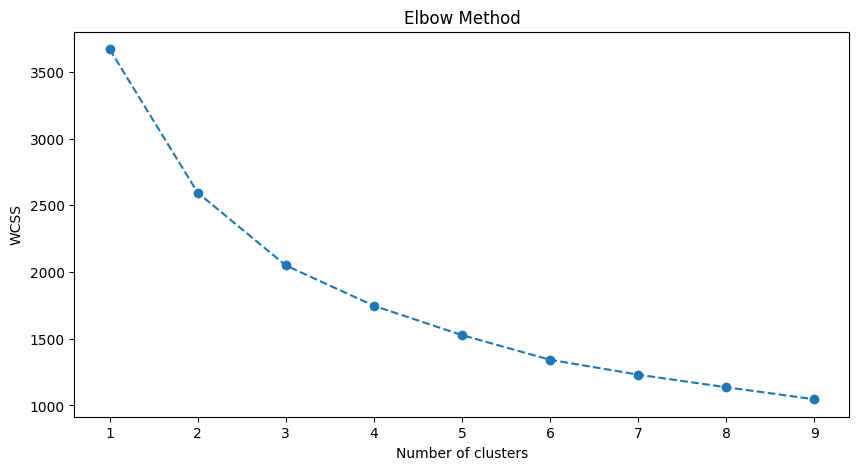

Cell Completed


In [4]:
# Separate training and testing data
training_data = data['2000':'2014']
test_data = data['2015':'2023']

indicators = ['VIX', 'ATR', 'SPY Volume', 'Yield Curve', 'Price Change']

# Drop NaN values from training data and keep only the necessary indicators
training_data = training_data[indicators].dropna()
test_data = test_data[indicators].dropna()
data = data.dropna()

# Scale the cleaned data
scaler = StandardScaler()
scaled_training_data = scaler.fit_transform(training_data)
scaled_test_data = scaler.fit_transform(test_data)
scaled_data = scaler.fit_transform(data)

# K-Means and Elbow Method
wcss = []
for i in range(1, 10):
    kmeans_ = KMeans(n_clusters=i, n_init=10, init='k-means++', random_state=42)
    kmeans_.fit(scaled_training_data)
    wcss.append(kmeans_.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 10), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

print("Cell Completed")

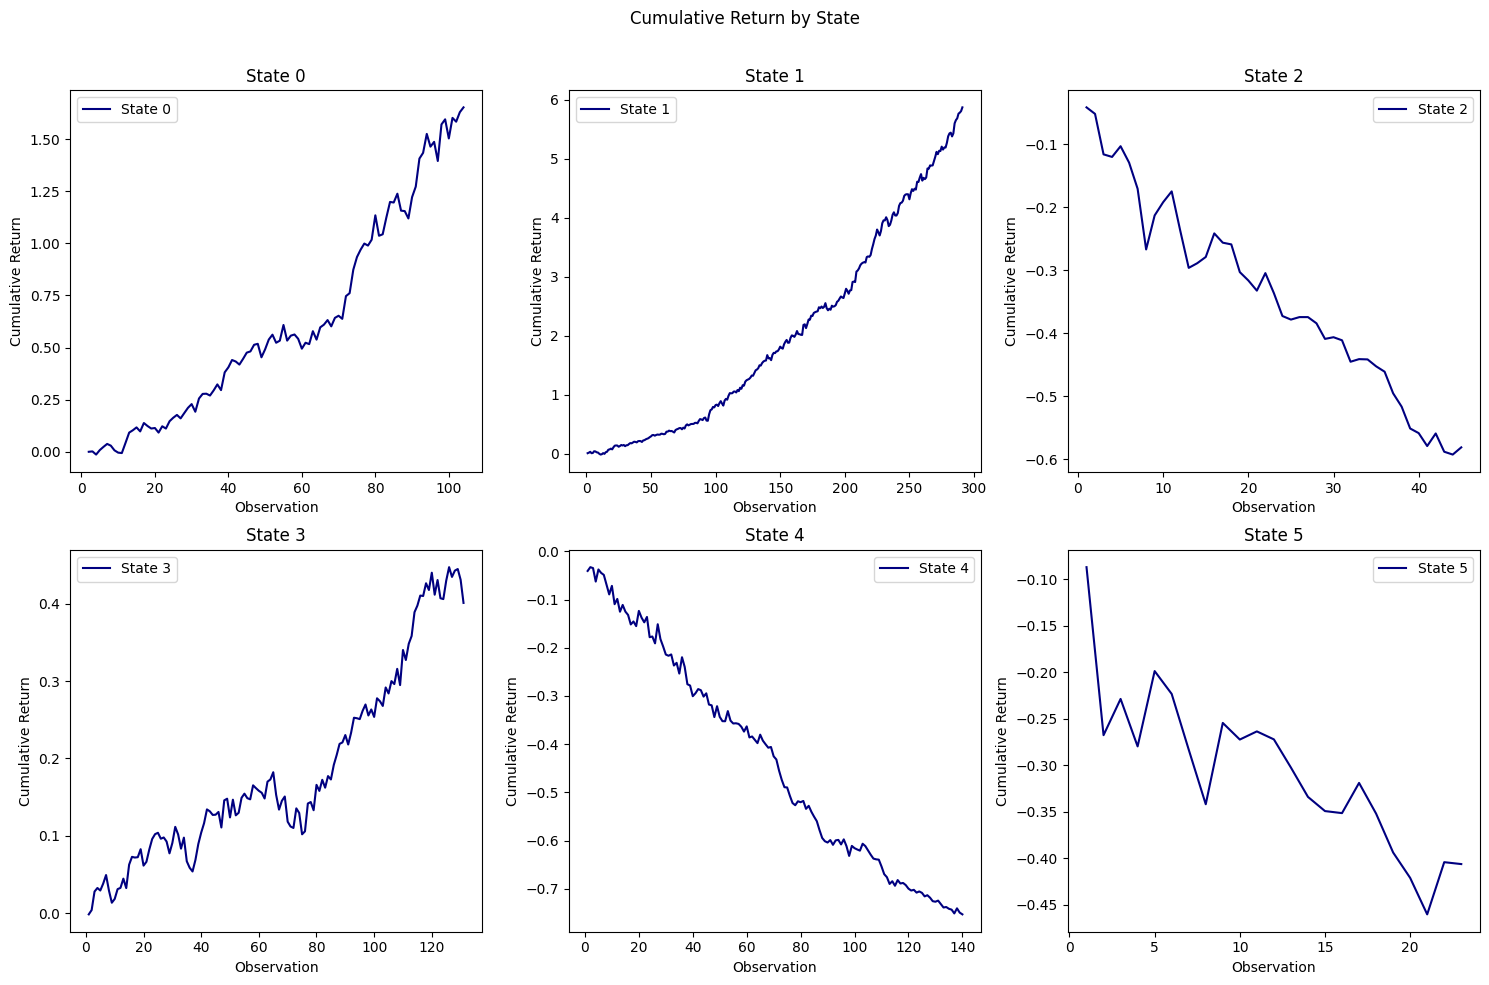

In [5]:
from tslearn.metrics import dtw
from tslearn.utils import to_time_series_dataset


# Train KMeans with 6 clusters
clusters = 6

kmeans = KMeans(n_clusters=clusters, n_init=10, init='k-means++', random_state=42)
kmeans.fit(scaled_training_data)

# Add States into the dataframe
training_data['State'] = kmeans.labels_

# Calculate SPY weekly returns
data['SPY Returns'] = data['Close_SPY'].pct_change()
training_data['SPY Returns'] = data['SPY Returns']
training_data['Close_SPY'] = data['Close_SPY']

# Create a column for cumulative returns for each state
for i in range(clusters):
    state_data = (training_data['State'] == i)
    training_data.loc[state_data, 'Cumulative Return'] = (1 + training_data.loc[state_data, 'SPY Returns']).cumprod() - 1

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle('Cumulative Return by State')

for i in range(clusters):
    row = i // 3
    col = i % 3
    ax = axes[row][col]

    subset = training_data[training_data['State'] == i]
    x_values = range(1, len(subset) + 1)  # x values starting from 1
    ax.plot(x_values, subset['Cumulative Return'], label=f'State {i}', color='navy')
    ax.set_title(f'State {i}')
    ax.set_xlabel('Observation')
    ax.set_ylabel('Cumulative Return')
    ax.legend()

# Adjust the layout to prevent overlaps
plt.tight_layout()
plt.subplots_adjust(top=0.90)  # Provide some space for the super title
plt.show()

training_data['Cumulative Return'] = training_data['Cumulative Return'].fillna(0)


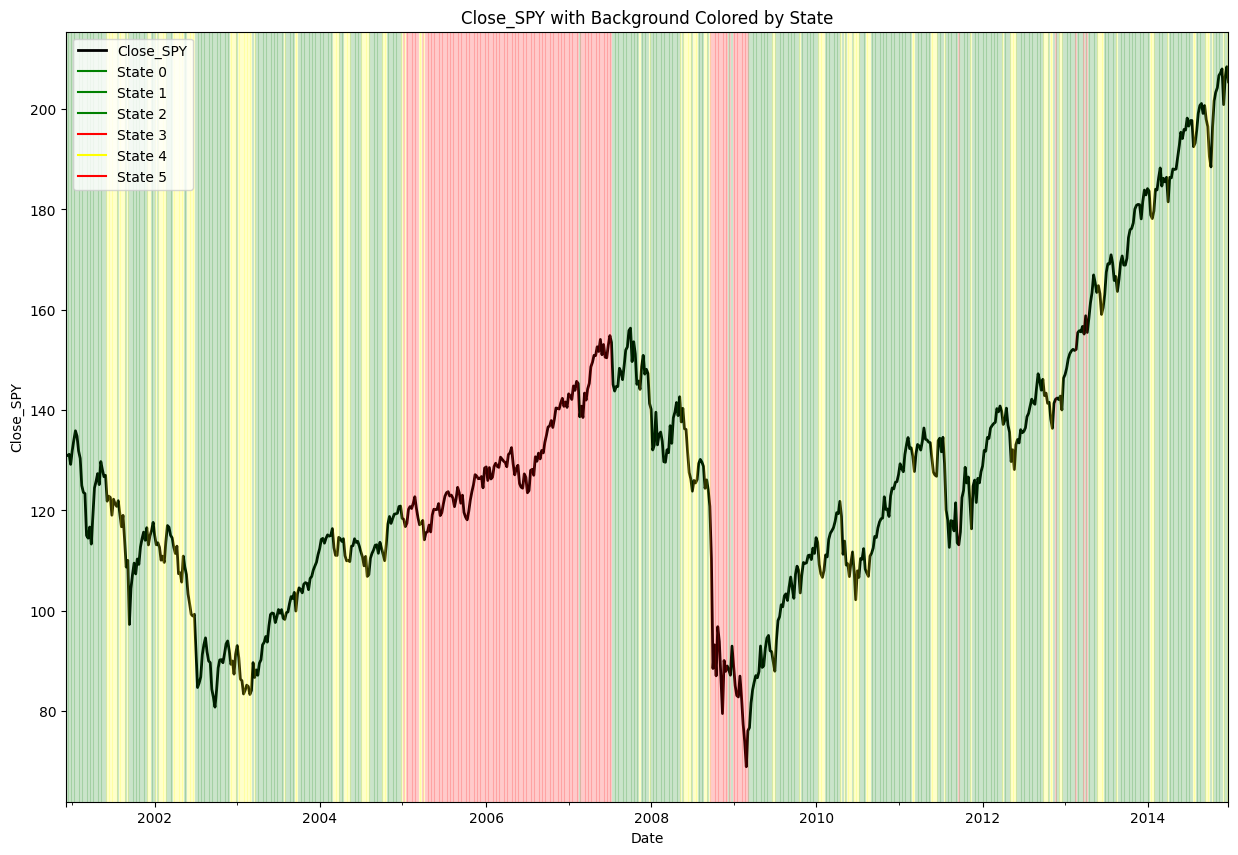

In [6]:
fig, ax = plt.subplots(figsize=(15, 10))
colors = ['green', 'green', 'red', 'green', 'yellow', 'red']

# Plot the Close_SPY column as a line
training_data['Close_SPY'].plot(ax=ax, color='black', lw=2)

# Draw vertical lines colored by state
training_data['State'].ffill()
for idx, row in training_data.iterrows():
    ax.axvline(x=idx, color=colors[int(row['State'])], alpha=0.2)

ax.set_title('Close_SPY with Background Colored by State')
ax.set_ylabel('Close_SPY')

# Optionally add a custom legend for states
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='black', lw=2, label='Close_SPY')] + [Line2D([0], [0], color=color, label=f'State {i}') for i, color in enumerate(colors)]
ax.legend(handles=legend_elements)

plt.show()

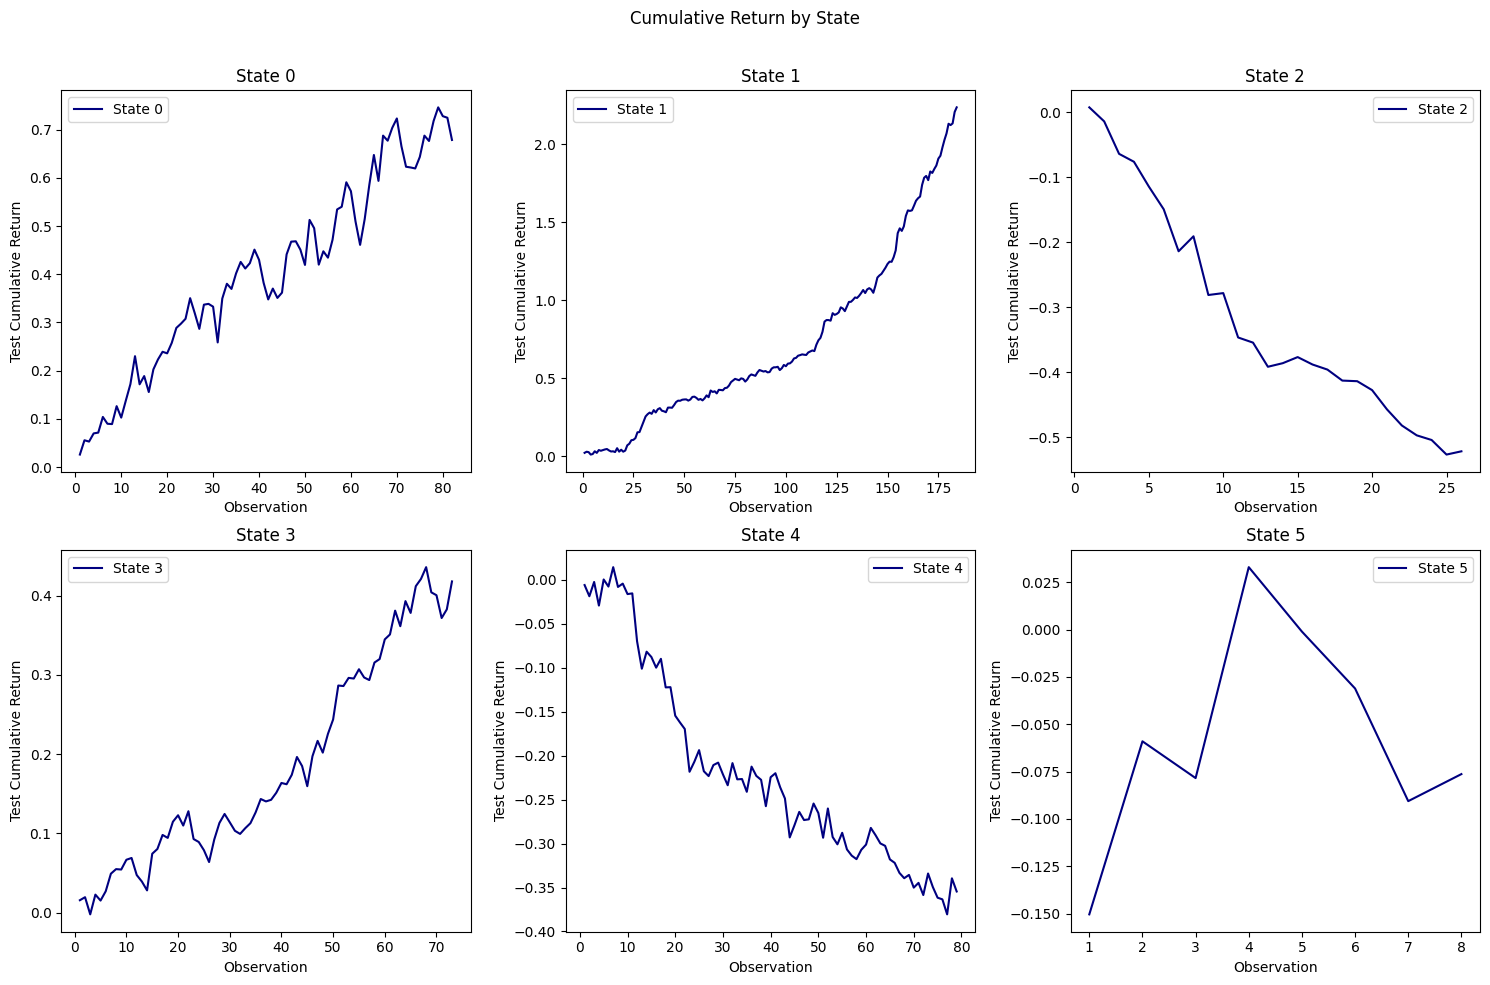

In [7]:
# Predict the states for the test data using the trained KMeans model
test_clusters = kmeans.predict(scaled_test_data)

test_data['State'] = test_clusters
test_data['SPY Returns'] = data['SPY Returns']
test_data['Close_SPY'] = data['Close_SPY']

# Create a column for cumulative returns for each state
for i in range(clusters):
    state_data = (test_data['State'] == i)
    test_data.loc[state_data, 'Cumulative Return'] = (1 + test_data.loc[state_data, 'SPY Returns']).cumprod() - 1

# Visualization
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle('Cumulative Return by State')

for i in range(clusters):
    row = i // 3
    col = i % 3
    ax = axes[row][col]

    subset = test_data[test_data['State'] == i]
    x_values = range(1, len(subset) + 1)  # x values starting from 1
    ax.plot(x_values, subset['Cumulative Return'], label=f'State {i}', color='navy')
    ax.set_title(f'State {i}')
    ax.set_xlabel('Observation')
    ax.set_ylabel('Test Cumulative Return')
    ax.legend()

# Adjust the layout to prevent overlaps
plt.tight_layout()
plt.subplots_adjust(top=0.90)  # Provide some space for the super title
plt.show()


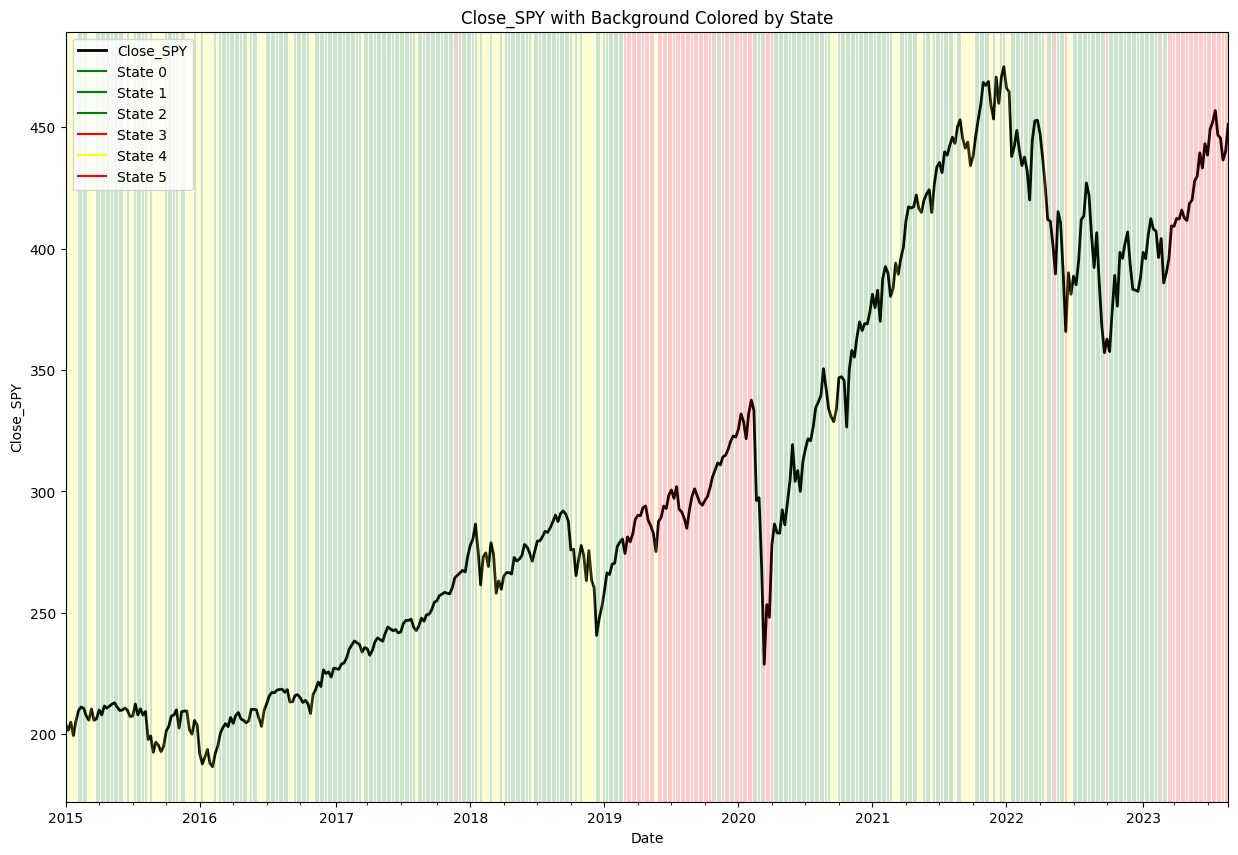

Cell Completed


In [8]:
fig, ax = plt.subplots(figsize=(15, 10))
colors = ['green', 'green', 'green', 'red', 'yellow', 'red']

# Plot the Close_SPY column as a line
test_data['Close_SPY'].plot(ax=ax, color='black', lw=2)

# Draw vertical lines colored by state
test_data['State'].ffill()
for idx, row in test_data.iterrows():
    ax.axvline(x=idx, color=colors[int(row['State'])], alpha=0.2)

ax.set_title('Close_SPY with Background Colored by State')
ax.set_ylabel('Close_SPY')

# Optionally add a custom legend for states
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='black', lw=2, label='Close_SPY')] + [Line2D([0], [0], color=color, label=f'State {i}') for i, color in enumerate(colors)]
ax.legend(handles=legend_elements, loc='upper left')

plt.show()
print("Cell Completed")

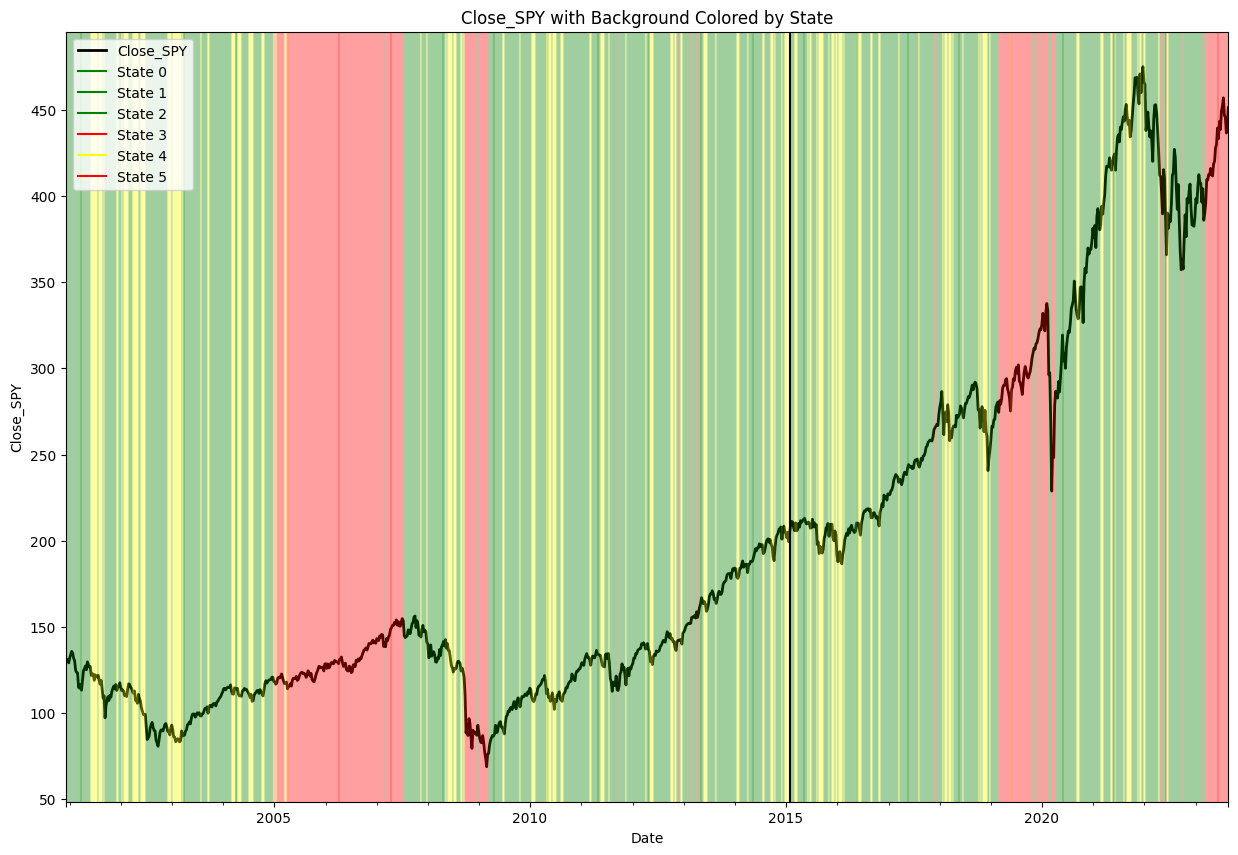

Cell Completed


In [9]:
import datetime

combined_data = pd.concat([training_data, test_data])
combined_data['Close_SPY'].ffill(inplace=True)
combined_data['State'].ffill(inplace=True)

fig, ax = plt.subplots(figsize=(15, 10))
colors = ['green', 'green', 'green', 'red', 'yellow', 'red']

# Plot the Close_SPY column as a line
combined_data['Close_SPY'].plot(ax=ax, color='black', lw=2)

# Draw vertical lines colored by state
test_data['State'].ffill()
for idx, row in combined_data.iterrows():
    ax.axvline(x=idx, color=colors[int(row['State'])], alpha=0.2)

ax.set_title('Close_SPY with Background Colored by State')
ax.axvline(datetime.date(2015, 1, 25), color = 'black')
ax.set_ylabel('Close_SPY')

# Optionally add a custom legend for states
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='black', lw=2, label='Close_SPY')] + [Line2D([0], [0], color=color, label=f'State {i}') for i, color in enumerate(colors)]
ax.legend(handles=legend_elements, loc='upper left')

plt.show()
print("Cell Completed")

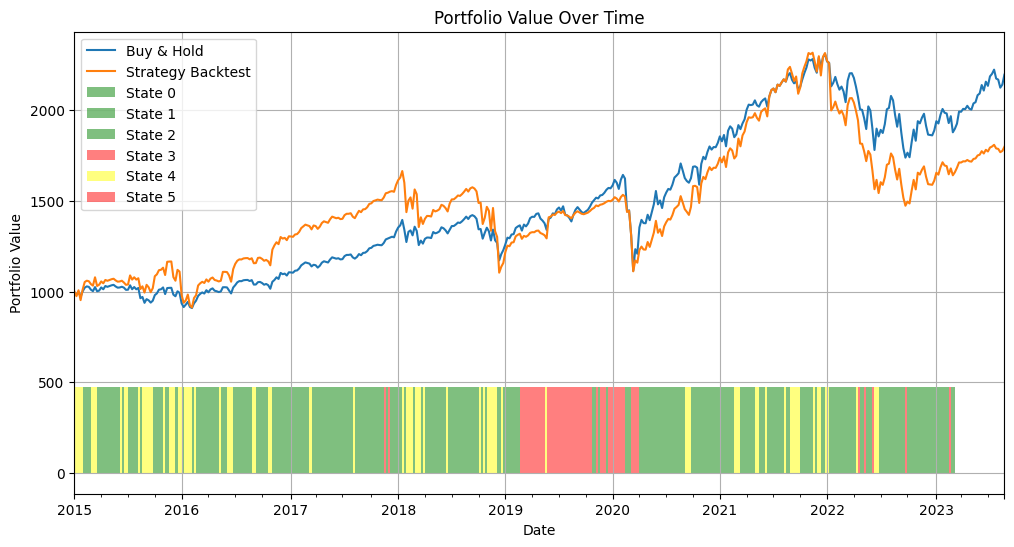

Annualized Sharpe Ratio (Strategy): 0.945567676586272
Annualized Sharpe Ratio (Buy & Hold): 1.3502302166105817


In [10]:
# Backtesting
# Setting up the initial values
test_data['BUY&Hold'] = 0
data['Strategy Backtest'] = 0
previous_state = None
buyhold = 1000
strategy_value = 1000

test_data['SPY Returns'].ffill()

double = False
exposure = 0
test_data['BUY&Hold'] = test_data['BUY&Hold'].astype(float)
for index, row in test_data.iterrows():

    # Buy & Hold Calculation
    buyhold *= (1 + row['SPY Returns'])
    test_data.at[index, 'BUY&Hold'] = buyhold

    # Strategy Calculation
    if previous_state in [0,1,2]:
        strategy_value *= (1 + row['SPY Returns'])
    elif previous_state in [3,5]:
        strategy_value *= (1 + row['SPY Returns']*0.5)
    elif previous_state in [4] or double:
        strategy_value *= (1 + (row['SPY Returns']*2))
    
    test_data.at[index, 'Strategy Backtest'] = strategy_value
    previous_state = row['State']

plt.figure(figsize=(12, 6))

test_data['BUY&Hold'].plot(label='Buy & Hold')
test_data['Strategy Backtest'].plot(label='Strategy Backtest')

plt.title('Portfolio Value Over Time')
plt.ylabel('Portfolio Value')
# Loop over each unique state
for state, color in enumerate(colors):
    # Create an array where the state matches
    mask = (combined_data['State'] == state).values
    # Where function will give us indices where transitions happen
    change_points = np.where(np.diff(mask.astype(int)))[0]

    # If the first element matches the state, add a start point at 0
    if mask[0]:
        change_points = np.insert(change_points, 0, 0)
    
    # Group change_points into start-end pairs for fill_between
    for start, end in zip(change_points[::2], change_points[1::2]):
        plt.fill_between(combined_data.index[start:end+1], 0, 
                         combined_data['Close_SPY'].max(), 
                         facecolor=color, alpha=0.5, label=f'State {state}')

plt.xlabel('Date')
handles, labels = plt.gca().get_legend_handles_labels()  # Get current handles and labels
by_label = dict(zip(labels, handles))  # Eliminate duplicate labels
plt.legend(by_label.values(), by_label.keys())  # Use only unique labels and handles
plt.grid(True)
plt.show()

# Assuming the risk-free rate is 0 for simplicity; you can replace this with an appropriate value if needed.
RISK_FREE_RATE = 0.0

# Calculate daily returns of the strategy
test_data['Strategy Daily Returns'] = test_data['Strategy Backtest'].pct_change()

# Calculate the daily returns for Buy & Hold
test_data['Buy&Hold Daily Returns'] = test_data['BUY&Hold'].pct_change()

# Calculate the expected return and the standard deviation of the returns for the strategy
expected_return_strategy = test_data['Strategy Daily Returns'].mean()
std_dev_strategy = test_data['Strategy Daily Returns'].std()

# Calculate the Sharpe Ratio for the strategy
sharpe_ratio_strategy = (expected_return_strategy - RISK_FREE_RATE) / std_dev_strategy

# Annualize the Sharpe Ratio for the strategy (assuming 252 trading days in a year)
annualized_sharpe_ratio_strategy = (252**0.5) * sharpe_ratio_strategy

# Calculate the expected return and the standard deviation of the returns for Buy & Hold
expected_return_buy_hold = test_data['Buy&Hold Daily Returns'].mean()
std_dev_buy_hold = test_data['Buy&Hold Daily Returns'].std()

# Calculate the Sharpe Ratio for Buy & Hold
sharpe_ratio_buy_hold = (expected_return_buy_hold - RISK_FREE_RATE) / std_dev_buy_hold

# Annualize the Sharpe Ratio for Buy & Hold (assuming 252 trading days in a year)
annualized_sharpe_ratio_buy_hold = (252**0.5) * sharpe_ratio_buy_hold

print("Annualized Sharpe Ratio (Strategy):", annualized_sharpe_ratio_strategy)
print("Annualized Sharpe Ratio (Buy & Hold):", annualized_sharpe_ratio_buy_hold)